In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/streetcardata2024/TTC Streetcar Delay Data 2022.xlsx
/kaggle/input/streetcardata2024/TTC Streetcar Delay Data 2024.xlsx
/kaggle/input/streetcardata2024/TTC Streetcar Delay Data 2023.xlsx


In [2]:
!pip -q install xgboost optuna

In [3]:
import xgboost as xgb # XGBoost model
import optuna # optimizing XGBoost model

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [22]:
data2024 = pd.read_excel('/kaggle/input/streetcardata2024/TTC Streetcar Delay Data 2024.xlsx')
data2023 = pd.read_excel('/kaggle/input/streetcardata2024/TTC Streetcar Delay Data 2023.xlsx')
data2022 = pd.read_excel('/kaggle/input/streetcardata2024/TTC Streetcar Delay Data 2022.xlsx')

In [40]:
df = pd.concat([data2024, data2023, data2022], axis=0)

if df.isna().any().any(): df.dropna(inplace=True)

In [41]:
df["DateTime"] = pd.to_datetime(df["Date"].dt.strftime("%Y-%m-%d") + " " + df["Time"])
df.drop(columns=["Date", "Time"], axis=1, inplace=True)

valid_lines = [501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 301, 303, 304, 305, 306, 310, 311, 312]
df = df[df['Line'].isin(valid_lines)] # keep only valid lines

df.drop(columns=["Bound", "Day"], axis=1, inplace=True)
df.drop(columns=["Vehicle"], axis=1, inplace=True)

df["Date"] = df["DateTime"].dt.day
df["Month"] = df["DateTime"].dt.month
df["Hour"] = df["DateTime"].dt.hour
df["Minute"] = df["DateTime"].dt.minute

df.drop(columns=["DateTime"], axis=1, inplace=True)

df["Line"] = df["Line"].astype(int)
df["Location"] = df["Location"].astype("category")
df["Incident"] = df["Incident"].astype("category")

In [42]:
df.head()

,Line,Location,Incident,Min Delay,Min Gap,Date,Month,Hour,Minute
0,505,DUNDAS AND MCCAUL,Security,10,20,1,1,2,45
1,505,COLLEGE AND GLADSTONE,Emergency Services,52,72,1,1,3,6
2,503,PARLIAMENT AND SHUTTER,Security,0,0,1,1,3,21
3,505,DUNDAS WEST STATION,Security,37,0,1,1,3,53
5,501,QUEEN AND BATHRUST,Diversion,74,84,1,1,4,33


In [43]:
X = df.drop(columns=["Min Delay"])
y = df["Min Delay"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=510)

## XGBoost Regression Model

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    reg_alpha =  trial.suggest_float('reg_alpha', 0.0, 35.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 10.0)
    
    model = xgb.XGBRegressor(
        n_estimators = n_estimators, # Weston Road North
        max_depth = max_depth,
        learning_rate = learning_rate,
        verbosity = 0,
        objective = 'reg:squarederror', # Use MSE
        booster = 'gbtree',
        subsample = 0.8,
        colsample_bytree = 0.8,
        eval_metric = 'rmse',
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        random_state = 510,
        enable_categorical = True
    )
    
    model.fit(X_train, y_train, eval_set = [(X_train, y_train)], verbose=False)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R^2 Value for Trial: {r2:.6f}")
    return r2

In [47]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-02-12 01:06:24,077] A new study created in memory with name: no-name-d0567250-d847-4050-8dc7-2e59dd3f6921
[I 2025-02-12 01:06:30,135] Trial 0 finished with value: 0.7255528289663673 and parameters: {'n_estimators': 347, 'max_depth': 8, 'learning_rate': 0.04529329330042246, 'reg_alpha': 24.574543407593332, 'reg_lambda': 9.73602471383835}. Best is trial 0 with value: 0.7255528289663673.


R^2 Value for Trial: 0.725553


[I 2025-02-12 01:06:32,042] Trial 1 finished with value: 0.7322490311073003 and parameters: {'n_estimators': 238, 'max_depth': 5, 'learning_rate': 0.018965486868109612, 'reg_alpha': 27.982589906557244, 'reg_lambda': 9.8856269765858}. Best is trial 1 with value: 0.7322490311073003.


R^2 Value for Trial: 0.732249


[I 2025-02-12 01:06:33,827] Trial 2 finished with value: 0.6951269610712218 and parameters: {'n_estimators': 234, 'max_depth': 5, 'learning_rate': 0.08260889646715304, 'reg_alpha': 22.025557198379165, 'reg_lambda': 6.713526569886309}. Best is trial 1 with value: 0.7322490311073003.


R^2 Value for Trial: 0.695127


[I 2025-02-12 01:06:38,320] Trial 3 finished with value: 0.6532419933891475 and parameters: {'n_estimators': 214, 'max_depth': 9, 'learning_rate': 0.111329371945395, 'reg_alpha': 20.990239160935037, 'reg_lambda': 2.229257921613581}. Best is trial 1 with value: 0.7322490311073003.


R^2 Value for Trial: 0.653242


[I 2025-02-12 01:06:45,425] Trial 4 finished with value: 0.6587025119056669 and parameters: {'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.2561311943043785, 'reg_alpha': 28.4286263537573, 'reg_lambda': 9.942839711565}. Best is trial 1 with value: 0.7322490311073003.


R^2 Value for Trial: 0.658703


[I 2025-02-12 01:06:45,999] Trial 5 finished with value: 0.7310373834773111 and parameters: {'n_estimators': 123, 'max_depth': 3, 'learning_rate': 0.021111624414402314, 'reg_alpha': 32.416815237520915, 'reg_lambda': 0.4335827669466852}. Best is trial 1 with value: 0.7322490311073003.


R^2 Value for Trial: 0.731037


[I 2025-02-12 01:06:49,333] Trial 6 finished with value: 0.7025064830783877 and parameters: {'n_estimators': 398, 'max_depth': 5, 'learning_rate': 0.012075145549561126, 'reg_alpha': 27.47758893359908, 'reg_lambda': 4.838285297061963}. Best is trial 1 with value: 0.7322490311073003.


R^2 Value for Trial: 0.702506


[I 2025-02-12 01:06:53,368] Trial 7 finished with value: 0.7409991479362663 and parameters: {'n_estimators': 392, 'max_depth': 4, 'learning_rate': 0.019279207120579518, 'reg_alpha': 15.501528049460605, 'reg_lambda': 5.855287854488106}. Best is trial 7 with value: 0.7409991479362663.


R^2 Value for Trial: 0.740999


[I 2025-02-12 01:06:54,424] Trial 8 finished with value: 0.6878503974072282 and parameters: {'n_estimators': 178, 'max_depth': 4, 'learning_rate': 0.21787895463401682, 'reg_alpha': 18.34141618806584, 'reg_lambda': 8.934350083905336}. Best is trial 7 with value: 0.7409991479362663.


R^2 Value for Trial: 0.687850


[I 2025-02-12 01:06:57,202] Trial 9 finished with value: 0.7160315567351858 and parameters: {'n_estimators': 469, 'max_depth': 4, 'learning_rate': 0.052789762468772115, 'reg_alpha': 26.163028489961487, 'reg_lambda': 5.631388458295103}. Best is trial 7 with value: 0.7409991479362663.


R^2 Value for Trial: 0.716032


In [48]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 392, 'max_depth': 4, 'learning_rate': 0.019279207120579518, 'reg_alpha': 15.501528049460605, 'reg_lambda': 5.855287854488106}


In [53]:
best_model = xgb.XGBRegressor(
    **best_params,
    enable_categorical=True,
    verbosity = 0,
    objective = 'reg:squarederror', # Use MSE
    booster = 'gbtree',
    subsample = 0.8,
    colsample_bytree = 0.8,
    eval_metric = 'rmse',
)
best_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.019279207120579518,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=392, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
y_test_pred = best_model.predict(X_test)
final_r2 = r2_score(y_test, y_test_pred)
print(f"Final Model R^2: {final_r2:.6f}")

Final Model R^2: 0.723686


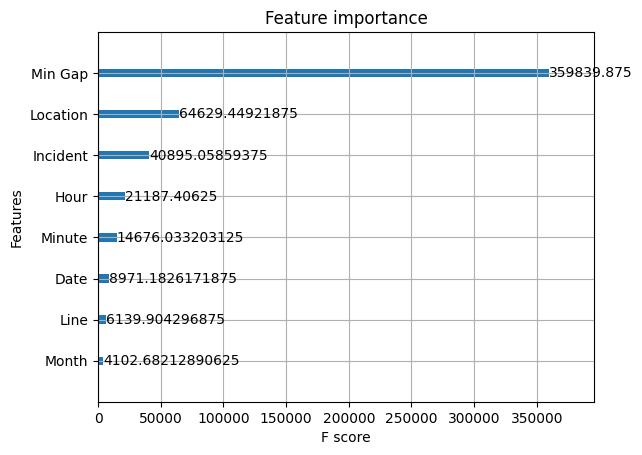

In [56]:
xgb.plot_importance(best_model, importance_type="gain")
plt.show()

In [57]:
# Seems like the date-time and line details are mostly irrelevant in predicting the delay
# we will keep hour though
engineered_df = df.drop(columns=["Date", "Line", "Month", "Minute"], axis=1)

In [58]:
engineered_df.head()

,Location,Incident,Min Delay,Min Gap,Hour
0,DUNDAS AND MCCAUL,Security,10,20,2
1,COLLEGE AND GLADSTONE,Emergency Services,52,72,3
2,PARLIAMENT AND SHUTTER,Security,0,0,3
3,DUNDAS WEST STATION,Security,37,0,3
5,QUEEN AND BATHRUST,Diversion,74,84,4


In [61]:
engineered_x = engineered_df.drop(columns=["Min Delay"], axis=1)
engineered_y = engineered_df["Min Delay"]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    engineered_x,
    engineered_y,
    test_size=0.2,
    random_state=510
)

In [63]:
eng_study = optuna.create_study(direction="maximize")
eng_study.optimize(objective, n_trials=10)

[I 2025-02-12 01:19:37,479] A new study created in memory with name: no-name-1e90753f-71f0-49dd-b300-fd3615f58bc5
[I 2025-02-12 01:19:39,838] Trial 0 finished with value: 0.6819249849844102 and parameters: {'n_estimators': 219, 'max_depth': 6, 'learning_rate': 0.19755379270269158, 'reg_alpha': 13.540286806513667, 'reg_lambda': 2.6421253143577594}. Best is trial 0 with value: 0.6819249849844102.


R^2 Value for Trial: 0.681925


[I 2025-02-12 01:19:43,279] Trial 1 finished with value: 0.7303198933950716 and parameters: {'n_estimators': 332, 'max_depth': 6, 'learning_rate': 0.21382765403068082, 'reg_alpha': 16.369122530723537, 'reg_lambda': 8.090858794432398}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.730320


[I 2025-02-12 01:19:45,128] Trial 2 finished with value: 0.6776717892122925 and parameters: {'n_estimators': 136, 'max_depth': 7, 'learning_rate': 0.04028635307891863, 'reg_alpha': 34.31349457218069, 'reg_lambda': 8.66635312176282}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.677672


[I 2025-02-12 01:19:51,442] Trial 3 finished with value: 0.5986003314673332 and parameters: {'n_estimators': 196, 'max_depth': 10, 'learning_rate': 0.012134284261216908, 'reg_alpha': 12.720545220099456, 'reg_lambda': 7.598416283622976}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.598600


[I 2025-02-12 01:19:54,381] Trial 4 finished with value: 0.7057614327226499 and parameters: {'n_estimators': 423, 'max_depth': 4, 'learning_rate': 0.013985267914072473, 'reg_alpha': 0.1756880060196253, 'reg_lambda': 3.336288986799797}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.705761


[I 2025-02-12 01:19:56,382] Trial 5 finished with value: 0.729257254581909 and parameters: {'n_estimators': 435, 'max_depth': 3, 'learning_rate': 0.05965071370139103, 'reg_alpha': 17.306850458577145, 'reg_lambda': 2.4282029417058926}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.729257


[I 2025-02-12 01:20:04,805] Trial 6 finished with value: 0.6799735527557754 and parameters: {'n_estimators': 311, 'max_depth': 8, 'learning_rate': 0.014640286097245995, 'reg_alpha': 6.07884872662477, 'reg_lambda': 8.816116271992371}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.679974


[I 2025-02-12 01:20:06,994] Trial 7 finished with value: 0.7179060314925827 and parameters: {'n_estimators': 471, 'max_depth': 3, 'learning_rate': 0.05012702783071144, 'reg_alpha': 18.267251559585443, 'reg_lambda': 8.28168778665339}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.717906


[I 2025-02-12 01:20:09,100] Trial 8 finished with value: 0.72637450881384 and parameters: {'n_estimators': 201, 'max_depth': 6, 'learning_rate': 0.12315331659272656, 'reg_alpha': 16.296037297670217, 'reg_lambda': 9.898162236161038}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.726375


[I 2025-02-12 01:20:13,848] Trial 9 finished with value: 0.5721444263759137 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.046155484009807915, 'reg_alpha': 10.494130889965723, 'reg_lambda': 0.8684727200785625}. Best is trial 1 with value: 0.7303198933950716.


R^2 Value for Trial: 0.572144


In [64]:
eng_best_model = xgb.XGBRegressor(
    **best_params,
    enable_categorical=True,
    verbosity = 0,
    objective = 'reg:squarederror', # Use MSE
    booster = 'gbtree',
    subsample = 0.8,
    colsample_bytree = 0.8,
    eval_metric = 'rmse',
)

eng_best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.019279207120579518,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=392, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [65]:
y_test_pred = eng_best_model.predict(X_test)
final_r2 = r2_score(y_test, y_test_pred)
print(f"Final Model R^2 for New Model: {final_r2:.6f}")

Final Model R^2 for New Model: 0.730285


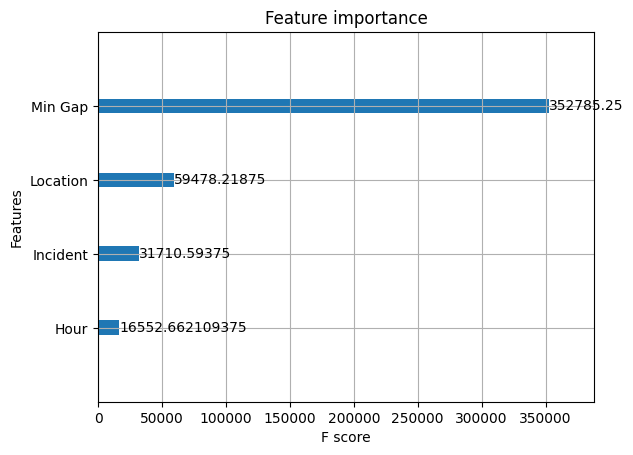

In [66]:
xgb.plot_importance(eng_best_model, importance_type="gain")
plt.show()